<a href="https://colab.research.google.com/github/vrlnarayana/capstone-gl/blob/main/SS_Matrix_factorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from google.colab import files
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')

# Remove scientific notations and display numbers with 2 decimal points instead
pd.options.display.float_format = '{:,.2f}'.format   

plt.rcParams["figure.figsize"] = [20, 6]  # width, height
plt.rcParams['xtick.direction'] = 'out'

In [19]:
song_data=pd.read_csv(r'/content/drive/My Drive/song_data_with_gender.csv')

In [20]:
count_data=pd.read_csv(r'/content/drive/My Drive/count_data.csv', index_col='Unnamed: 0') #Making unnamed: 0 an index column

In [21]:
song_data.drop(song_data[song_data.duplicated('song_id')].index, inplace=True)
len(song_data)

999056

In [31]:
count_data_with_song_info_df = pd.merge(count_data, song_data, on="song_id", how="left")

In [32]:
count_data_with_song_info_df.head(10)

,user_id,song_id,play_count,Unnamed: 0,title,release,artist_name,year,artist_gender
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,397229,The Cove,Thicker Than Water,Jack Johnson,0,male
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,4822,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,female
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,133174,Stronger,Graduation,Kanye West,2007,male
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,971391,Constellations,In Between Dreams,Jack Johnson,2005,male
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,930757,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999,male
5,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODDNQT12A6D4F5F7E,5,521570,Apuesta Por El Rock 'N' Roll,Antología Audiovisual,Héroes del Silencio,2007,male
6,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODXRTY12AB0180F3B,1,292254,Paper Gangsta,The Fame Monster,Lady GaGa,2008,female
7,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFGUAY12AB017B0A8,1,561728,Stacked Actors,There Is Nothing Left To Lose,Foo Fighters,1999,male
8,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOFRQTD12A81C233C0,1,808198,Sehr kosmisch,Musik von Harmonia,Harmonia,0,female
9,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOHQWYZ12A6D4FA701,1,147425,Heaven's gonna burn your eyes,Hôtel Costes 7 by Stéphane Pompougnac,Thievery Corporation feat. Emiliana Torrini,2002,female


In [33]:
count_data_with_song_info_df = count_data_with_song_info_df.drop(columns=['Unnamed: 0'])

In [34]:
count_data_with_song_info_df

,user_id,song_id,play_count,title,release,artist_name,year,artist_gender
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1,The Cove,Thicker Than Water,Jack Johnson,0,male
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,Entre Dos Aguas,Flamenco Para Niños,Paco De Lucia,1976,female
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,Stronger,Graduation,Kanye West,2007,male
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBYHAJ12A6701BF1D,1,Constellations,In Between Dreams,Jack Johnson,2005,male
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SODACBL12A8C13C273,1,Learn To Fly,There Is Nothing Left To Lose,Foo Fighters,1999,male
...,...,...,...,...,...,...,...,...
1999995,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJEYPO12AAA8C6B0E,2,Ignorance (Album Version),Ignorance,Paramore,0,female
1999996,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJJYDE12AF729FC16,4,Two Is Better Than One,Love Drunk,Boys Like Girls featuring Taylor Swift,2009,male
1999997,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJKQSF12A6D4F5EE9,3,What I've Done (Album Version),What I've Done,Linkin Park,2007,male
1999998,d8bfd4ec88f0f3773a9e022e3c1a0f1d3b7b6a92,SOJUXGA12AC961885C,1,Up,My Worlds,Justin Bieber,2010,male


AxesSubplot(0.125,0.125;0.775x0.755)


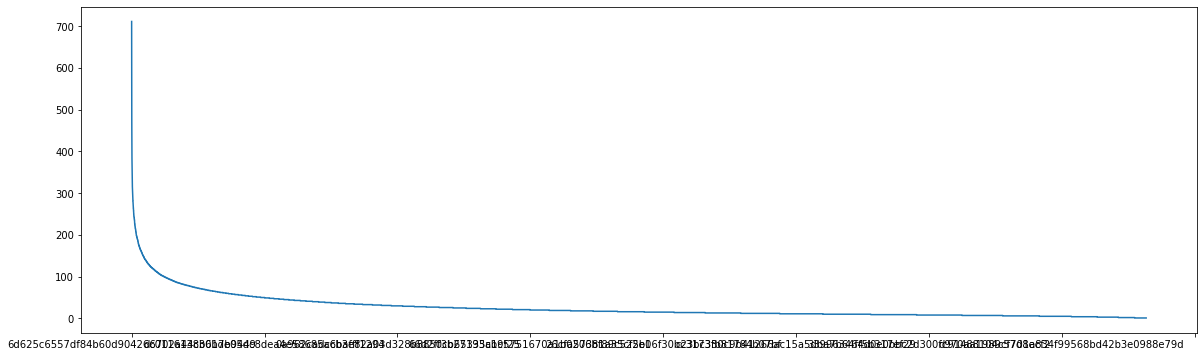

In [35]:
#Modified by Lakshminarayanan

#Commented Sachin's code below
#count_data_with_song_info_df=count_data_with_song_info_df.iloc[0:50000,] # we should take user who have played more no of songs than top 50k records
#users = count_data_with_song_info_df['user_id'].unique()
#len(users)

counts = count_data_with_song_info_df['user_id'].value_counts()
print(counts.plot())

In [36]:
#Modified by Lakshminarayanan
#Based on the above plot consider users who have played 60 times or more
count_data_with_song_info_df_final = count_data_with_song_info_df[count_data_with_song_info_df['user_id'].isin(counts[counts >= 60].index)]
count_data_with_song_info_df_final

,user_id,song_id,play_count,title,release,artist_name,year,artist_gender
130,b64cdd1a0bd907e5e00b39e345194768e330d652,SOAFTRR12AF72A8D4D,3,Harder Better Faster Stronger,Discovery,Daft Punk,2007,male
131,b64cdd1a0bd907e5e00b39e345194768e330d652,SOALEQA12A58A77839,1,Jumping Jack Flash,Shine A Light,The Rolling Stones,1982,male
132,b64cdd1a0bd907e5e00b39e345194768e330d652,SOATNYF12AF72A8D48,3,Aerodynamic,Discovery,Daft Punk,2001,male
133,b64cdd1a0bd907e5e00b39e345194768e330d652,SOBDKVR12A8C13E705,1,You Know What You Are?,With Teeth,Nine Inch Nails,2005,male
134,b64cdd1a0bd907e5e00b39e345194768e330d652,SOBDMNP12AF72AB1E1,2,Indo Silver Club,Homework,Daft Punk,1996,male
...,...,...,...,...,...,...,...,...
1999765,9fb0717a34c90c91ce09ab460969a8a428d3ac87,SOZOIUU12A67ADFA39,1,He Can Only Hold Her,Back To Black,Amy Winehouse,2006,female
1999766,9fb0717a34c90c91ce09ab460969a8a428d3ac87,SOZPLKR12A6D4F8421,5,Drunk Kid Catholic,Noise Floor [Rarities 98 - 05],Bright Eyes,2000,male
1999767,9fb0717a34c90c91ce09ab460969a8a428d3ac87,SOZRILK12A8C139F4F,2,Cool Dry Place (2007 Remastered LP Version),Traveling Wilburys Vol. 3,Traveling Wilburys,0,male
1999768,9fb0717a34c90c91ce09ab460969a8a428d3ac87,SOZWQWL12A58A7EA09,3,Let's Live For Today,150 Rock 'N' Roll Classics,The Grass Roots,1987,male


In [37]:
#Modified by Lakshminarayanan
users = count_data_with_song_info_df_final['user_id'].unique()
len(users)

7298

## User-Song - Derive and normalize Implicit Rating 
We do not have “rating” in our data; all we have are the play counts of various songs which can be considered as “implicit feedback”. We will replace the play count with a fractional play count. The logic being that this will measure the strength of “likeness” for a song in the range of [0,1]. 

In [42]:
#Modified by Lakshminarayanan
user_song_sum_df = count_data_with_song_info_df_final[['user_id','play_count']].groupby('user_id').sum().reset_index()

In [43]:
user_song_sum_df.rename(columns={'play_count':'total_play_count'},inplace=True)

In [44]:
count_data_with_song_info_df = pd.merge(count_data_with_song_info_df,user_song_sum_df)
count_data_with_song_info_df['fractional_play_count'] = count_data_with_song_info_df['play_count']/count_data_with_song_info_df['total_play_count']

In [45]:
count_data_with_song_info_df.tail(5)

,user_id,song_id,play_count,title,release,artist_name,year,artist_gender,total_play_count,fractional_play_count
736509,9fb0717a34c90c91ce09ab460969a8a428d3ac87,SOZOIUU12A67ADFA39,1,He Can Only Hold Her,Back To Black,Amy Winehouse,2006,female,798,0.00
736510,9fb0717a34c90c91ce09ab460969a8a428d3ac87,SOZPLKR12A6D4F8421,5,Drunk Kid Catholic,Noise Floor [Rarities 98 - 05],Bright Eyes,2000,male,798,0.01
736511,9fb0717a34c90c91ce09ab460969a8a428d3ac87,SOZRILK12A8C139F4F,2,Cool Dry Place (2007 Remastered LP Version),Traveling Wilburys Vol. 3,Traveling Wilburys,0,male,798,0.00
736512,9fb0717a34c90c91ce09ab460969a8a428d3ac87,SOZWQWL12A58A7EA09,3,Let's Live For Today,150 Rock 'N' Roll Classics,The Grass Roots,1987,male,798,0.00
736513,9fb0717a34c90c91ce09ab460969a8a428d3ac87,SOZXVUF12AC909762A,2,Your Picture,Underachievers Please Try Harder,Camera Obscura,0,female,798,0.00


## Create utility matrix¶
convert the dataframe into a numpy matrix in
the format of utility matrix

In [46]:
from scipy.sparse import coo_matrix

In [47]:
small_set = count_data_with_song_info_df
user_codes = small_set['user_id'].drop_duplicates().reset_index()
song_codes = small_set['song_id'].drop_duplicates().reset_index() 
user_codes.rename(columns={'index':'user_index'}, inplace=True) 
song_codes.rename(columns={'index':'song_index'}, inplace=True) 

In [48]:
song_codes['so_index_value'] = list(song_codes.index)
user_codes['us_index_value'] = list(user_codes.index)
small_set = pd.merge(small_set,song_codes,how='left')
small_set = pd.merge(small_set,user_codes,how='left')
mat_candidate = small_set[['us_index_value','so_index_value','fractional_play_count']] 
data_array = mat_candidate['fractional_play_count'].values
row_array = mat_candidate['us_index_value'].values
col_array = mat_candidate['so_index_value'].values
data_sparse = coo_matrix((data_array, (row_array, col_array)),dtype=float)

In [49]:
data_sparse.shape

(7298, 10000)

In [50]:
len(user_codes)

7298

In [51]:
len(song_codes)

10000

In [52]:
user_codes[user_codes['user_id'] =='befdd50134a9ad0e512d1604d057b540cbef87dd']

,user_index,user_id,us_index_value


### Singular Value Decomposition
we will use the svds function provided by the scipy library to break down our utility matrix into three different matrices. We will use 50 latent factors


In [ ]:
import math as mt
from scipy.sparse.linalg import * #used for matrix multiplication
from scipy.sparse.linalg import svds
from scipy.sparse import csc_matrix

In [ ]:

def compute_svd(urm, K):
    U, s, Vt = svds(urm, K)

    dim = (len(s), len(s))
    S = np.zeros(dim, dtype=np.float32)
    for i in range(0, len(s)):
        S[i,i] = mt.sqrt(s[i])

    U = csc_matrix(U, dtype=np.float32)
    S = csc_matrix(S, dtype=np.float32)
    Vt = csc_matrix(Vt, dtype=np.float32)
    
    return U, S, Vt

def compute_estimated_matrix(urm, U, S, Vt, uTest, K, test):
    rightTerm = S*Vt 
    max_recommendation = 250
    estimatedRatings = np.zeros(shape=(MAX_UID, MAX_PID), dtype=np.float16)
    recomendRatings = np.zeros(shape=(MAX_UID,max_recommendation ), dtype=np.float16)
    for userTest in uTest:
        prod = U[userTest, :]*rightTerm
        estimatedRatings[userTest, :] = prod.todense()
        recomendRatings[userTest, :] = (-estimatedRatings[userTest, :]).argsort()[:max_recommendation]
    return recomendRatings

In [ ]:
K=50
urm = data_sparse
MAX_PID = urm.shape[1]
MAX_UID = urm.shape[0]
U, S, Vt = compute_svd(urm, K)

In [ ]:
uTest = [4,5,6,7,8,873,23]

uTest_recommended_items = compute_estimated_matrix(urm, U, S, Vt, uTest, K, True)

In [ ]:
for user in uTest:
    print("Recommendation for user with user id {}". format(user))
    rank_value = 1
    for i in uTest_recommended_items[user,0:10]:
        song_details = small_set[small_set.so_index_value == i].drop_duplicates('so_index_value')[['title','artist_name']]
        print("The number {} recommended song is {} BY {}".format(rank_value, list(song_details['title'])[0],list(song_details['artist_name'])[0]))
        rank_value+=1

Recommendation for user with user id 4
The number 1 recommended song is Found Home BY 59 Times the Pain
The number 2 recommended song is Under The Bridge (Album Version) BY Red Hot Chili Peppers
The number 3 recommended song is Walking For You BY The Avett Brothers
The number 4 recommended song is Make Love To Your Mind BY Bill Withers
The number 5 recommended song is Dog Days Are Over (Radio Edit) BY Florence + The Machine
The number 6 recommended song is The Devil Never Sleeps (Album) BY Iron And Wine
The number 7 recommended song is The Gift BY Angels and Airwaves
The number 8 recommended song is Sincerité Et Jalousie BY Alliance Ethnik
The number 9 recommended song is Horn Concerto No. 4 in E flat K495: II. Romance (Andante cantabile) BY Barry Tuckwell/Academy of St Martin-in-the-Fields/Sir Neville Marriner
The number 10 recommended song is Can't Have You BY Jonas Brothers
Recommendation for user with user id 5
The number 1 recommended song is Invalid BY Tub Ring
The number 2 recom